In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12089
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    47|[28 58 80 58 80 5...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    28|[78 5B 78 5B 20 5...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[10 5A 20 5B A0 5...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[98 5A F0 5A 78 5...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[A0 5B D0 5B 14 5...|2006.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00088529')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)


SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00088529'
13 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       PRCP|USC00088529|    11|[00 00 00 00 00 0...|2000.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       PRCP|USC00088529|    45|[00 7E 00 7E 00 7...|2001.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(13, 365)

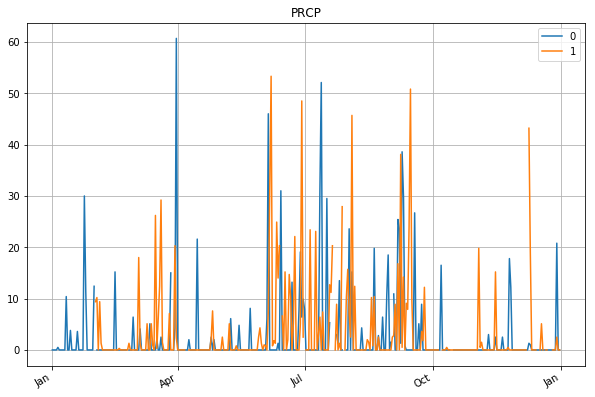

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


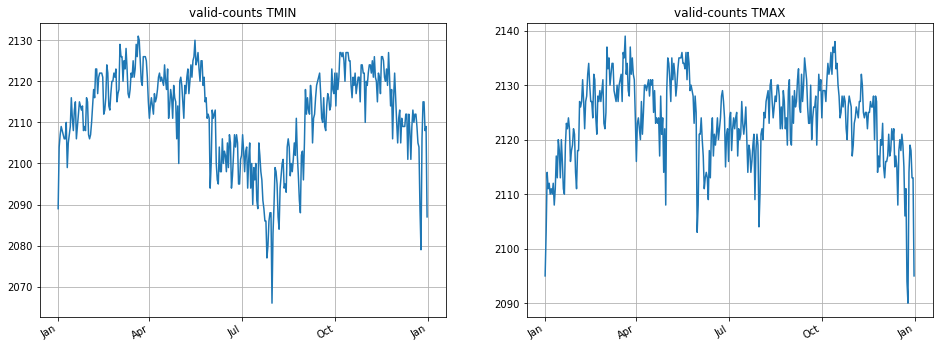

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

### Plots of mean and std of observations

In [54]:


def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

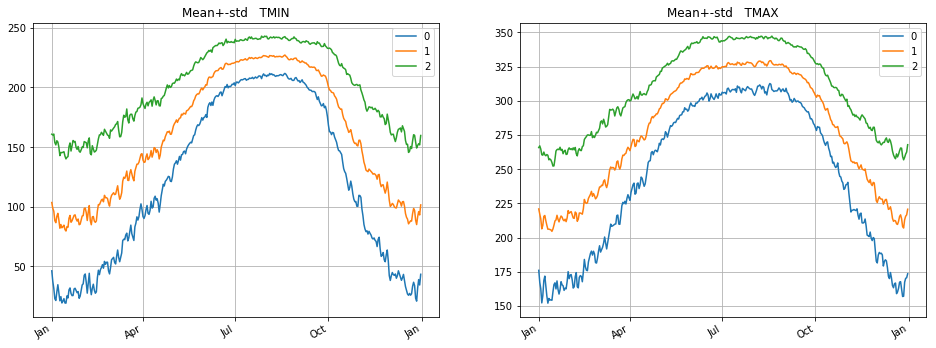

In [7]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

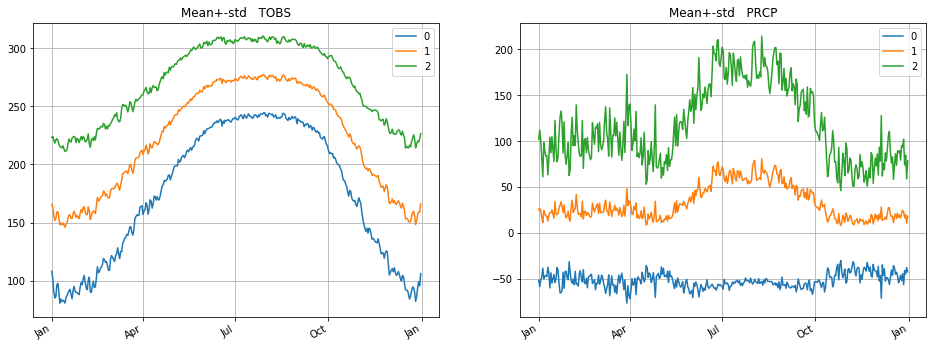

In [8]:
plot_pair(['TOBS', 'PRCP'],plot_mean_std)

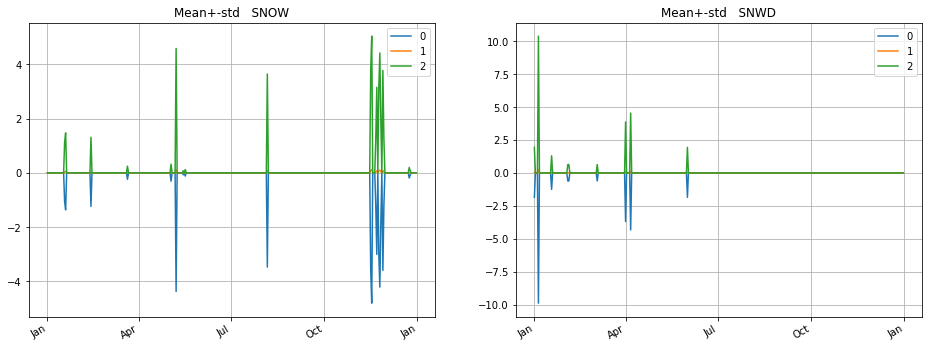

In [9]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [10]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

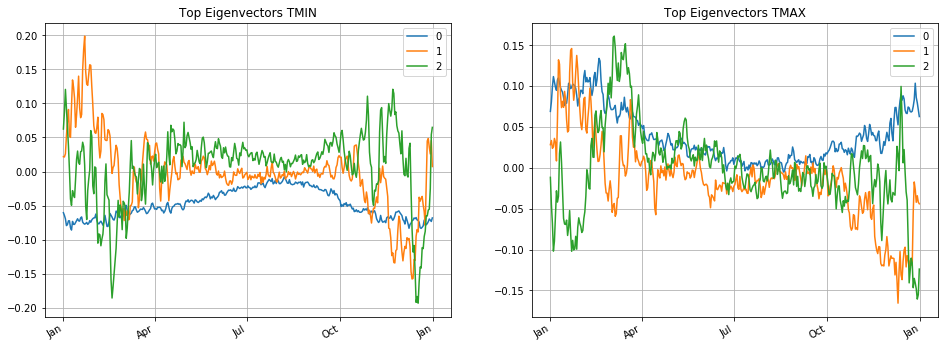

In [11]:
plot_pair(['TMIN','TMAX'],plot_eigen)

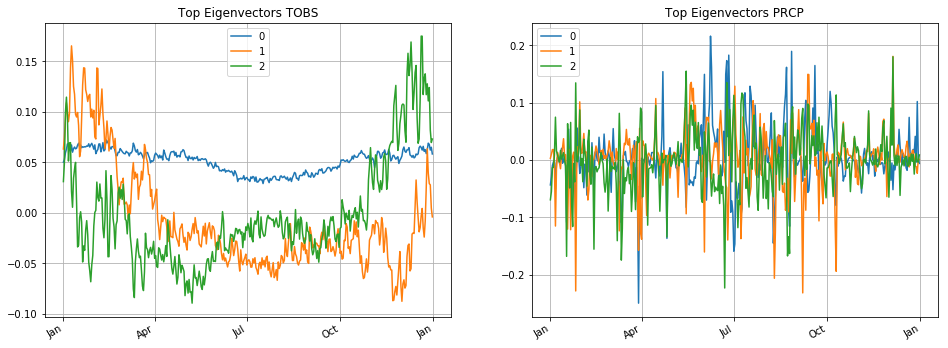

In [12]:
plot_pair(['TOBS','PRCP'],plot_eigen)

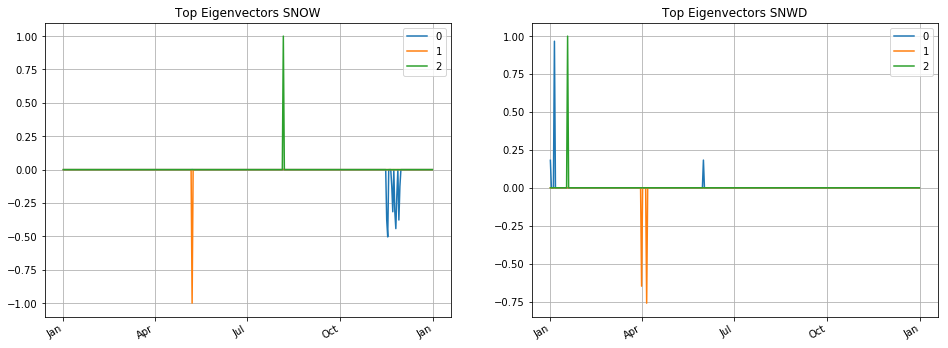

In [13]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [14]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

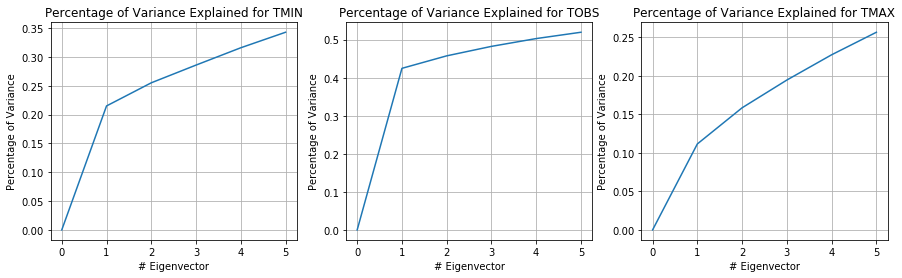

In [15]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

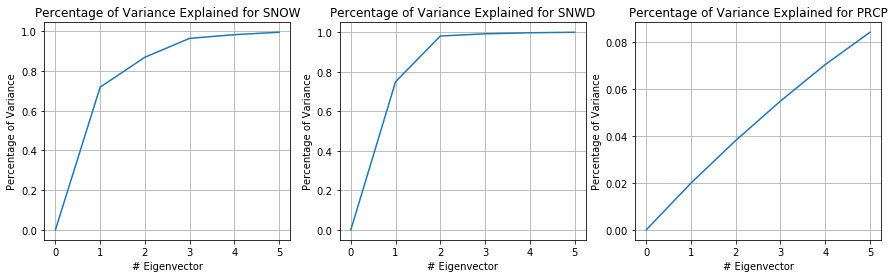

In [16]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

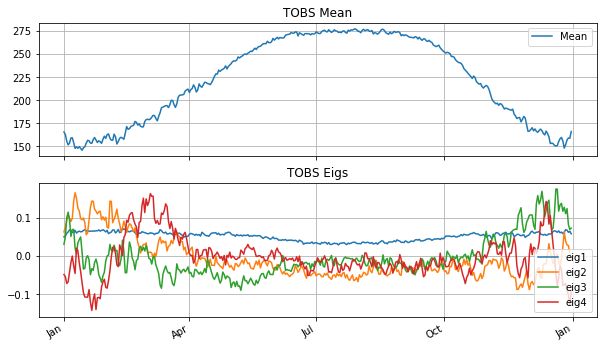

In [56]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
m = 'TOBS'
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [18]:
df_TOBS=df.filter(df.measurement==m)
df_TOBS.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|    48|[40 4C 30 55 80 4...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|    29|[00 7E 70 5A F0 5...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[E0 54 90 55 F0 5...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[A0 56 80 58 F0 5...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[B0 58 B8 59 60 5...|2006.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [19]:
rows=df_TOBS.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(1651, 365)

In [20]:
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.173645051314
residual normalized norm  after mean + top eigs: [ 0.27232305  0.26229825  0.26223698]


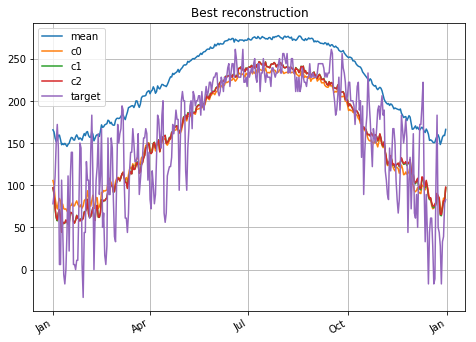

In [21]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

In [24]:
Query1="SELECT latitude, longitude FROM weather\n\tWHERE measurement='%s'"%('TOBS')
dflatlong = sqlContext.sql(Query1)

In [30]:
a = dflatlong.rdd.map(lambda x: [x[0],x[1]])

In [31]:
b = a.collect()

In [33]:
b = np.array(b)

In [38]:
minlatlong = np.max(b, axis=0)

In [39]:
minlatlong

array([ 30.1064, -82.0333])

In [46]:
Query1="SELECT station FROM weather"
dfyear = sqlContext.sql(Query1)


In [47]:
a = dfyear.rdd.map(lambda x: x[0])

In [48]:
b = a.collect()

TypeError: plot() got an unexpected keyword argument 'ylabel'

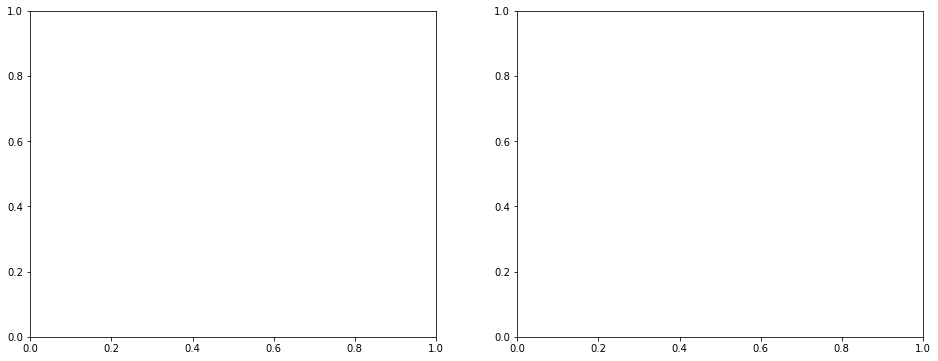

In [55]:
plot_pair(['SNWD','SNOW'],plot_mean)